In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

import EMNIST data - original NIST data stored by original writer of data

In [2]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [3]:
len(emnist_train.client_ids)


3383

In [4]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

Example of dataset for a writer

In [5]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

In [6]:
example_dataset

<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>

In [7]:
example_element = next(iter(example_dataset))

In [8]:
example_element

OrderedDict([('label', <tf.Tensor: shape=(), dtype=int32, numpy=5>),
             ('pixels',
              <tf.Tensor: shape=(28, 28), dtype=float32, numpy=
              array([[1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        ],
                     [1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 1.        ,
                      1.        , 1.        , 

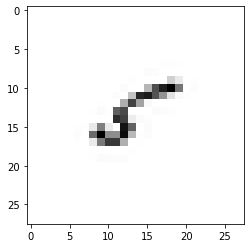

In [9]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

Show the data for a writter

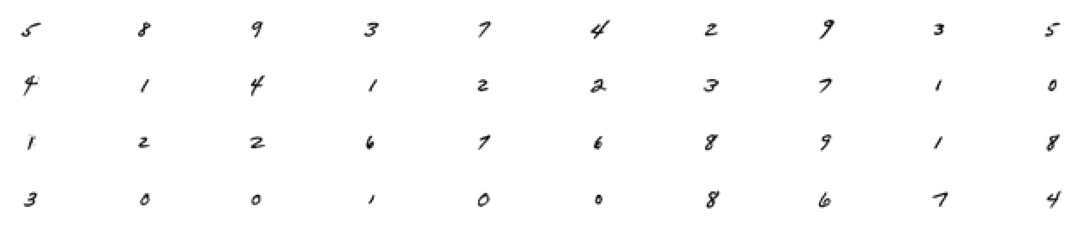

In [10]:

figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

Preprocessing the data from 28x28 matrix to vector

In [15]:

NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [12]:
preprocessed_example_dataset = preprocess(example_dataset)

In [13]:
preprocessed_example_dataset

<PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>

Helper to process the data for all clients

In [14]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

Sample from NUM_CLients clients

In [16]:
NUM_CLIENTS=10
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]
federated_train_data = make_federated_data(emnist_train, sample_clients)

In [17]:
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# Create Keras model

Create the layers. THe model should not be compiled

In [18]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(512, activation='relu', input_shape=(28 * 28,)),
      tf.keras.layers.Dense(10, activation='softmax'),
  ])

Wrap the keras model in a tff model and specify the loss and metrics

In [19]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Build the averaging process.The optimizer is specified at this step.

In [21]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Let's invoke the initialize computation to construct the server state.

In [25]:
import nest_asyncio
nest_asyncio.apply()
state = iterative_process.initialize()

The next function represents a round of computation. Push model to client, collect, average update.

In [26]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12757201), ('loss', 2.759342)]))])


Run more rounds

In [27]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.18395062), ('loss', 2.2264495)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.22942387), ('loss', 2.1251676)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2761317), ('loss', 2.037192)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2899177), ('loss', 1.9812325)]))])
round  6, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('va